In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
from loadData import load_data, processData

time_arr_multisetpoint, mu_arr_multisetpoint, pulse_arr_multisetpoint, \
            time_arr_actdeact, mu_arr_actdeact, pulse_arr_actdeact, \
            time_arr_pid, mu_arr_pid, pulse_arr_pid, \
            time_arr_pid2, mu_arr_pid2, pulse_arr_pid2, \
            time_arr_mpc, mu_arr_mpc, pulse_arr_mpc, \
            time_arr_mpc2, mu_arr_mpc2, pulse_arr_mpc2, \
            time_arr_mpc3, mu_arr_mpc3, pulse_arr_mpc3, \
            time_arr_mpc4, mu_arr_mpc4, pulse_arr_mpc4, \
            keys_unique, mu_unique, mu_std_unique = load_data()

In [3]:
def processData(time_array, mu_array, pulse_array, embed_dim=10, step_pred=1):
    mu = mu_next = torch.tensor(mu_array).float().clone()
    L_past = L_next = torch.tensor(pulse_array).float().clone()
    time_past = time_next = torch.tensor(time_array).float().clone()

    return mu, mu_next, L_past, L_next, time_past, time_next



In [4]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# Multilayer Perceptron
class GRUModel(torch.nn.Module):
    def __init__(self, hidden_size, num_traj, device):
        super(GRUModel, self).__init__()

        self.network = torch.nn.GRU(1, hidden_size, 1, batch_first=True)
        # self.output = torch.nn.Linear(hidden_size, 1)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Sigmoid()
        )
        self.num_traj = num_traj

        self.h0 = (torch.zeros(1, self.num_traj, hidden_size) + 0.5).to(device).requires_grad_()
        # self.c0 = torch.zeros(1, self.num_traj, hidden_size).to(device).requires_grad_()

    def forward(self, u, h=None):
        if h is None: 
            out = self.network(u, self.h0)
        else:
            out = self.network(u, h)
        out = self.output(out[0].data)

        return out

    def network_direct(self, u, h=None):
        if h is None: 
            out = self.network(u, self.h0)
        else:
            out = self.network(u, h)

        return out[0]


In [5]:
embed_dim = 1
step_pred = 100000

def process_thisdata(step_pred):
    # Process the data
    mu_pid, mu_next_pid, L_past_pid, L_arr_pid, time_arr_past_pid, time_arr_next_pid = processData(time_arr_pid, mu_arr_pid, pulse_arr_pid, embed_dim=embed_dim, step_pred=step_pred)
    mu_pid2, mu_next_pid2, L_past_pid2, L_arr_pid2, time_arr_past_pid2, time_arr_next_pid2 = processData(time_arr_pid2, mu_arr_pid2, pulse_arr_pid2, embed_dim=embed_dim, step_pred=step_pred)
    mu_mpc, mu_next_mpc, L_past_mpc, L_arr_mpc, time_arr_past_mpc, time_arr_next_mpc = processData(time_arr_mpc, mu_arr_mpc, pulse_arr_mpc, embed_dim=embed_dim, step_pred=step_pred)
    mu_mpc2, mu_next_mpc2, L_past_mpc2, L_arr_mpc2, time_arr_past_mpc2, time_arr_next_mpc2 = processData(time_arr_mpc2, mu_arr_mpc2, pulse_arr_mpc2, embed_dim=embed_dim, step_pred=step_pred)
    mu_mpc3, mu_next_mpc3, L_past_mpc3, L_arr_mpc3, time_arr_past_mpc3, time_arr_next_mpc3 = processData(time_arr_mpc3, mu_arr_mpc3, pulse_arr_mpc3, embed_dim=embed_dim, step_pred=step_pred)
    mu_mpc4, mu_next_mpc4, L_past_mpc4, L_arr_mpc4, time_arr_past_mpc4, time_arr_next_mpc4 = processData(time_arr_mpc4, mu_arr_mpc4, pulse_arr_mpc4, embed_dim=embed_dim, step_pred=step_pred)
    mu_actdeact, mu_next_actdeact, L_past_actdeact, L_arr_actdeact, time_arr_past_actdeact, time_arr_next_actdeact = processData(time_arr_actdeact, mu_arr_actdeact, pulse_arr_actdeact, embed_dim=embed_dim, step_pred=step_pred)
    mu_multisetpoint, mu_next_multisetpoint, L_past_multisetpoint, L_arr_multisetpoint, time_arr_past_multisetpoint, time_arr_next_multisetpoint = processData(time_arr_multisetpoint, mu_arr_multisetpoint, pulse_arr_multisetpoint, embed_dim=embed_dim, step_pred=step_pred)

    # Choose the data to use
    mu_to_use = [mu_mpc3, mu_mpc4, mu_pid, mu_actdeact, mu_multisetpoint]
    mu_next_to_use = [mu_next_mpc3, mu_next_mpc4, mu_next_pid, mu_next_actdeact, mu_next_multisetpoint]
    L_past_to_use = [L_past_mpc3, L_past_mpc4, L_past_pid, L_past_actdeact, L_past_multisetpoint]
    L_arr_to_use = [L_arr_mpc3, L_arr_mpc4, L_arr_pid,  L_arr_actdeact, L_arr_multisetpoint]
    time_arr_past_to_use = [time_arr_past_mpc3, time_arr_past_mpc4, time_arr_past_pid, time_arr_past_actdeact, time_arr_past_multisetpoint]
    time_arr_next_to_use = [time_arr_next_mpc3, time_arr_next_mpc4, time_arr_next_pid, time_arr_next_actdeact, time_arr_next_multisetpoint]

    # Collate lengths of each dataset
    length_arr = list(map(lambda x: x.size(dim=0), mu_to_use))
    max_length = max(length_arr)

    # Concatenate all data tensors into one by padding with zeros
    mu_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), mu_to_use))).unsqueeze(2)
    mu_next_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), mu_next_to_use))).unsqueeze(2)
    L_past_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), L_past_to_use))).unsqueeze(2)
    L_arr_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), L_arr_to_use))).unsqueeze(2)
    time_arr_past_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), time_arr_past_to_use))).unsqueeze(2)
    time_arr_next_train = torch.stack(list(map(lambda x: torch.functional.F.pad(x, (0, max_length - len(x))), time_arr_next_to_use))).unsqueeze(2)

    # Create packed padded sequence
    mu_train = torch.nn.utils.rnn.pack_padded_sequence(mu_train, length_arr, batch_first=True, enforce_sorted=False)
    mu_next_train = torch.nn.utils.rnn.pack_padded_sequence(mu_next_train, length_arr, batch_first=True, enforce_sorted=False)
    L_past_train = torch.nn.utils.rnn.pack_padded_sequence(L_past_train, length_arr, batch_first=True, enforce_sorted=False)
    L_arr_train = torch.nn.utils.rnn.pack_padded_sequence(L_arr_train, length_arr, batch_first=True, enforce_sorted=False)
    time_arr_past_train = torch.nn.utils.rnn.pack_padded_sequence(time_arr_past_train, length_arr, batch_first=True, enforce_sorted=False)
    time_arr_next_train = torch.nn.utils.rnn.pack_padded_sequence(time_arr_next_train, length_arr, batch_first=True, enforce_sorted=False)

    return mu_train, mu_next_train, L_past_train, L_arr_train, time_arr_past_train, time_arr_next_train

In [6]:
keys_unique = np.array([0.,    0.005, 0.01,  0.015, 0.02,  0.03,  0.05,  0.1  ])
mu_unique = np.array([0.02850882637414166, 0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.18971876855552988])

L_train_ss = []
mu_train_ss = []
for i in range(len(keys_unique)):
    L_train_ss.append(torch.tensor(np.ones((1, embed_dim)) * keys_unique[i]).float().to(device))
    mu_train_ss.append(torch.tensor(np.ones((1, embed_dim-1)) * mu_unique[i]).float().to(device))
L_train_ss = torch.cat(L_train_ss, dim=0)
mu_train_ss = torch.cat(mu_train_ss, dim=0)

print(mu_train_ss.shape)
print(L_train_ss.shape)

torch.Size([8, 0])
torch.Size([8, 1])


In [7]:
torch.cuda.device_count()

0

In [8]:
torch.device('cuda:0')

device(type='cuda', index=0)

In [9]:
# # Load model
# filename = "latentRHS_jupyter3.pt"
# filepath = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/DataDriven/savedModels/" + filename

# max_dt = torch.tensor(0.36).to(device)
# model = LatentRHS(encoder_params, decoder_params, latent_dim, functional_params, max_dt, device)#.to(device)
# model.load_state_dict(torch.load(filepath, map_location='cpu'))
# model.to(device)


In [10]:
hidden_size = 10
num_traj = 5

In [11]:
from tqdm import tqdm, trange

dt = torch.tensor(0.5).to(device)
max_dt = torch.tensor(0.36).to(device)
model = GRUModel(hidden_size, num_traj, device).to(device)

# Training parameters
num_epochs = 50000
lr = 0.02
batch_size = 128

# Train the model
train_loss_list = []
val_loss_list = []

class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

mu_train, mu_next_train, L_past_train, L_arr_train, _, _ = process_thisdata(step_pred)

# Move to GPU
mu_train = mu_train.to(device)
L_past_train = L_past_train.to(device)

# Loss and optimizer and scheduler
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
# Use mean squared logarithmic error
# criterion = RMSLELoss()

optimizer = torch.optim.AdamW([
                    {'params': model.parameters()},
                    {'params': model.h0, 'lr': 0.1}
                    ], 
                    lr=lr, weight_decay=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs), eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=0.0001, threshold_mode='rel', cooldown=100, min_lr=0, eps=1e-08, verbose=True)


In [12]:
pbar = trange(int(num_epochs), leave=False, desc="Step Prediction: {}, Train Loss: {:.4e}".format(step_pred, 0))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs), eta_min=1e-6)
for epoch in pbar:

    mu_pred = model(L_past_train)
    loss = criterion(mu_pred, mu_train.data)
    train_loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description("Step Prediction: {}, Train Loss: {:.4e}".format(step_pred, loss))
    scheduler.step()

Text(0, 0.5, 'Loss')

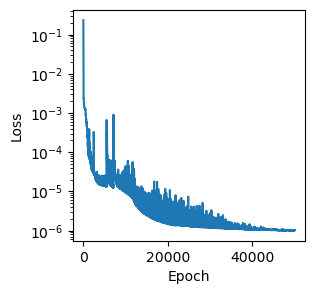

In [13]:
# Plot loss
plt.figure(figsize=(3,3))
plt.semilogy(train_loss_list, label="Train Loss")
# plt.semilogy(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

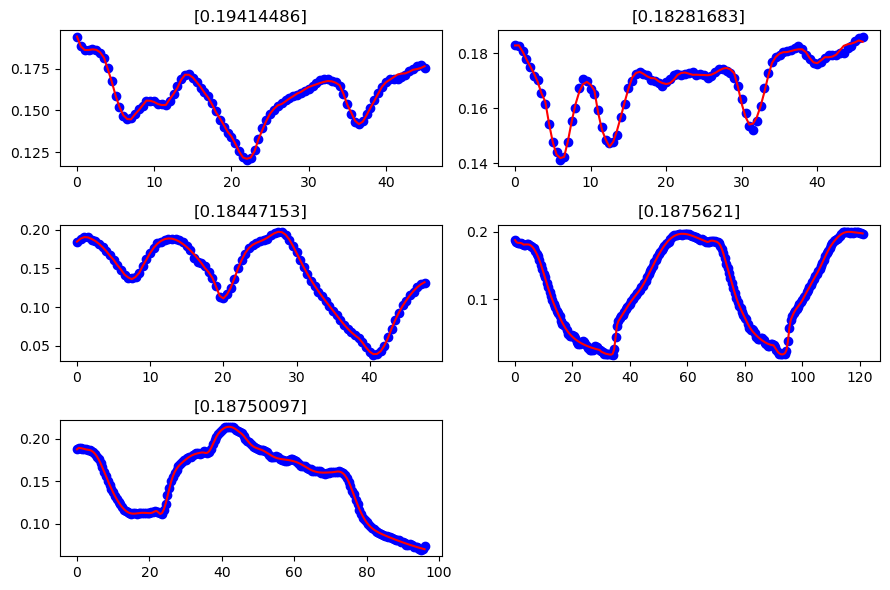

In [14]:
L_unpacked, L_unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(L_past_train, batch_first=True)
mu_unpacked, mu_unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(mu_train, batch_first=True)

num_trajs = L_unpacked.shape[0]

fig = plt.figure(figsize=(3*int(np.ceil(num_trajs/2)), 6))
for i in range(num_trajs):
    mu_pred = model(L_unpacked[[i],:, :].to(device), model.h0[:, [i], :])
    time_array = np.arange(0, L_unpacked.shape[1]*0.5, 0.5)

    ax = fig.add_subplot(int(np.ceil(num_trajs/2)), 2, i+1)
    ax.plot(time_array[:L_unpacked_len[i]], mu_unpacked[i].cpu().detach().numpy()[:L_unpacked_len[i]], 'o', color='blue')
    ax.plot(time_array[:L_unpacked_len[i]], mu_pred.cpu().detach().numpy()[0, :L_unpacked_len[i]], color='red')
    ax.set_title(str(mu_pred.cpu().detach().numpy()[0, :L_unpacked_len[i]][0]))

plt.tight_layout()

In [15]:
print(model.h0)

tensor([[[-3.1231,  2.1717, -1.0947,  1.6405,  0.7189,  1.0599, -0.2093,
           1.3078, -0.0248, -0.5419],
         [-1.1557,  2.0257, -0.2783,  2.1067, -0.0484, -0.3386, -0.9300,
           0.2899, -0.2103, -1.1868],
         [ 2.4122, -4.9233, -2.2014,  3.2296,  1.9934,  1.4824, -2.0556,
           2.0170, -1.2205,  1.5189],
         [-2.5386,  0.4847, -1.2681,  0.3914,  1.2981, -3.0431, -0.9000,
           0.0150, -0.9158,  1.8382],
         [-1.2123,  1.8646, -1.1072,  0.8191,  0.5797,  0.0400, -0.0997,
           1.7682, -1.1641,  0.5768]]], device='cuda:0', requires_grad=True)


In [16]:
from scipy.optimize import fsolve

def fsolve_fun(h, u):
    h = torch.tensor(h).float().to(device).unsqueeze(0).unsqueeze(0)
    u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
    network_out = model.network_direct(u, h)
    output = network_out.cpu().detach().numpy() - h.cpu().detach().numpy()
    return output.flatten()

h_guess = np.random.rand((hidden_size))*1
u = np.array([0.01])
h = fsolve(fsolve_fun, h_guess, args=(u))
print(h)
h = torch.tensor(h).float().to(device).unsqueeze(0).unsqueeze(0)
u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
network_out = model.network_direct(u, h)

print(network_out.cpu().detach().numpy())

output = model.output(network_out)

print(output.cpu().detach().numpy())

[-6.96834443  1.01805402 -0.12796719  8.06600097  6.58123293 -1.55104647
  0.71744276  4.1828014  -0.08214777  2.52441184]
[[[-6.968305    1.018054   -0.12791273  8.065945    6.5812235
   -1.5510465   0.7174427   4.1827955  -0.0821474   2.52434   ]]]
[[[1.6430786e-05]]]


/home/smalani/.conda/envs/torch-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 1238
         Function evaluations: 1969


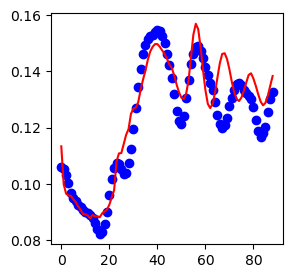

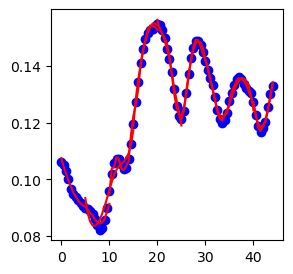

In [57]:
from scipy.optimize import minimize

def min_fun(h, u, mu):
    h = torch.tensor(h).float().to(device).unsqueeze(0).unsqueeze(0)
    u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u, h)
    output = np.mean((mu_pred.cpu().detach().numpy().flatten() - mu) ** 2)
    return output

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
# h_guess = np.zeros((hidden_size))
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_mpc, mu_arr_mpc, pulse_arr_mpc, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy()
mu = mu_mpc.cpu().detach().numpy()
h = minimize(min_fun, h_guess, args=(u, mu), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': True})
# print(h)

h = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
mu_pred = model(u, h)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(mu_mpc, 'o', color='blue')
ax.plot(mu_pred.cpu().detach().numpy().flatten(), color='red')

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_mpc, mu_arr_mpc, pulse_arr_mpc, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy().squeeze()
mu = mu_mpc.cpu().detach().numpy()
time_array = np.arange(0, len(mu)*0.5, 0.5)

time_start_arr = np.arange(0, 45, 5)
time_forecast = 10

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(time_array, mu_mpc, 'o', color='blue')

for time_start in time_start_arr:
    u_use = u[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    mu_use = mu[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    time_use = time_array[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    h = minimize(min_fun, h_guess, args=(u_use, mu_use), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': False})

    h_model = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
    u_model = torch.tensor(u_use).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u_model, h_model)
    ax.plot(time_use, mu_pred.cpu().detach().numpy().flatten(), color='red')

In [28]:
mu.shape

(89,)

Optimization terminated successfully.
         Current function value: 0.000146
         Iterations: 831
         Function evaluations: 1433


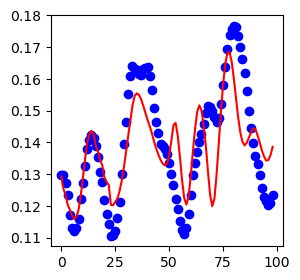

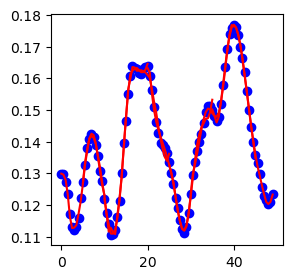

In [56]:
from scipy.optimize import minimize

def min_fun(h, u, mu):
    h = torch.tensor(h).float().to(device).unsqueeze(0).unsqueeze(0)
    u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u, h)
    output = np.mean((mu_pred.cpu().detach().numpy().flatten() - mu) ** 2)
    return output

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
# h_guess = np.zeros((hidden_size))
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_mpc2, mu_arr_mpc2, pulse_arr_mpc2, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy()
mu = mu_mpc.cpu().detach().numpy()
h = minimize(min_fun, h_guess, args=(u, mu), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': True})
# print(h)

h = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
mu_pred = model(u, h)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(mu_mpc, 'o', color='blue')
ax.plot(mu_pred.cpu().detach().numpy().flatten(), color='red')

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_mpc2, mu_arr_mpc2, pulse_arr_mpc2, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy().squeeze()
mu = mu_mpc.cpu().detach().numpy()
time_array = np.arange(0, len(mu)*0.5, 0.5)

time_start_arr = np.arange(0, 45, 5)
time_forecast = 10

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(time_array, mu_mpc, 'o', color='blue')

for time_start in time_start_arr:
    u_use = u[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    mu_use = mu[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    time_use = time_array[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    h = minimize(min_fun, h_guess, args=(u_use, mu_use), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': False})

    h_model = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
    u_model = torch.tensor(u_use).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u_model, h_model)
    ax.plot(time_use, mu_pred.cpu().detach().numpy().flatten(), color='red')

Optimization terminated successfully.
         Current function value: 0.001732
         Iterations: 1218
         Function evaluations: 1940


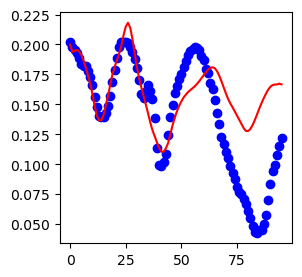

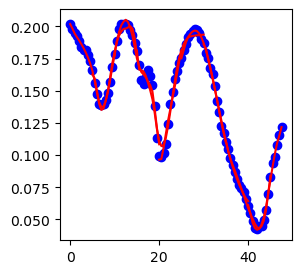

In [55]:
from scipy.optimize import minimize

def min_fun(h, u, mu):
    h = torch.tensor(h).float().to(device).unsqueeze(0).unsqueeze(0)
    u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u, h)
    output = np.mean((mu_pred.cpu().detach().numpy().flatten() - mu) ** 2)
    return output

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
# h_guess = np.zeros((hidden_size))
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_pid2, mu_arr_pid2, pulse_arr_pid2, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy()
mu = mu_mpc.cpu().detach().numpy()
h = minimize(min_fun, h_guess, args=(u, mu), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': True})
# print(h)

h = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
u = torch.tensor(u).float().to(device).unsqueeze(0).unsqueeze(2)
mu_pred = model(u, h)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(mu_mpc, 'o', color='blue')
ax.plot(mu_pred.cpu().detach().numpy().flatten(), color='red')

h_guess = model.h0[0, 0, :].cpu().detach().numpy()
mu_mpc, _, L_past_mpc, _, _, _ = processData(time_arr_pid2, mu_arr_pid2, pulse_arr_pid2, embed_dim=embed_dim, step_pred=step_pred)
u = L_past_mpc.cpu().detach().numpy().squeeze()
mu = mu_mpc.cpu().detach().numpy()
time_array = np.arange(0, len(mu)*0.5, 0.5)

time_start_arr = np.arange(0, 45, 5)
time_forecast = 10

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.plot(time_array, mu_mpc, 'o', color='blue')

for time_start in time_start_arr:
    u_use = u[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    mu_use = mu[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    time_use = time_array[np.logical_and(time_array >= time_start, time_array <= time_start + time_forecast)]
    h = minimize(min_fun, h_guess, args=(u_use, mu_use), method='Nelder-Mead', tol=1e-9, options={'maxiter': 10000, 'disp': False})

    h_model = torch.tensor(h.x).float().to(device).unsqueeze(0).unsqueeze(0)
    u_model = torch.tensor(u_use).float().to(device).unsqueeze(0).unsqueeze(2)
    mu_pred = model(u_model, h_model)
    ax.plot(time_use, mu_pred.cpu().detach().numpy().flatten(), color='red')

In [24]:
mu_mpc.shape

torch.Size([56])

In [25]:
assert False

AssertionError: 

In [ ]:
total_params = sum(
	param.numel() for param in model.parameters()
)

print(total_params)

In [ ]:
hidden_arr = model.network_direct(L_past_train.to(device)).data.detach().to(device)
hidden_input = mu_train.data.detach().to(device)

In [ ]:
print(torch.max(hidden_arr, dim=0).values)
print(torch.min(hidden_arr, dim=0).values)

In [ ]:
num_epochs = 1000
lr = 0.01

encoder_model = torch.nn.Sequential(torch.nn.Linear(1, 64),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(64, 64),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(64, hidden_size)).to(device)
encoder_model.to(device)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(encoder_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs), eta_min=1e-6)

pbar = trange(int(num_epochs), leave=False, desc="Step Prediction: {}, Train Loss: {:.4e}, Val Loss: {:.4e}".format(step_pred, train_loss, val_loss))

train_loss_list_encoder = []

for epoch in pbar:
    hidden_pred = encoder_model(hidden_input)
    loss = criterion(hidden_pred, hidden_arr)

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_list_encoder.append(loss.item())

    pbar.set_description("Step Prediction: {}, Train Loss: {:.4e}".format(step_pred, loss))
    scheduler.step()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.semilogy(train_loss_list_encoder, label='Train Loss')


In [ ]:
mu_pred.shape

In [ ]:
# Save model
overwrite = False
filename = "GRU_model.pt"
filepath = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/DataDriven/savedModels/" + filename

if overwrite:
    torch.save(model.state_dict(), filepath)


In [ ]:
step_pred = 20

mu_train, mu_next_train, L_past_train, L_arr_train, time_arr_past_train, time_arr_next_train = process_thisdata(step_pred)

mu_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

# Plot prediction
plt.figure()
plt.plot(mu_next_train[...,[-1]].detach().cpu().numpy().flatten(), mu_pred.flatten(), 'o')
# plt.plot(mu_train[...,[-1]].detach().cpu().numpy(), mu_pred, 'ok')
plt.xlabel("True")
plt.ylabel("Predicted")

In [ ]:
mu_next_train.shape
# mu_train_pred.shape

In [ ]:
# Training Data Viz

step_pred = 60

fig = plt.figure(figsize=(10, 10))

mu_pid, mu_next_pid, L_past_pid, L_arr_pid, time_arr_past_pid, time_arr_next_pid = processData(time_arr_pid, mu_arr_pid, pulse_arr_pid, embed_dim=embed_dim, step_pred=step_pred)
mu_pid2, mu_next_pid2, L_past_pid2, L_arr_pid2, time_arr_past_pid2, time_arr_next_pid2 = processData(time_arr_pid2, mu_arr_pid2, pulse_arr_pid2, embed_dim=embed_dim, step_pred=step_pred)
mu_mpc, mu_next_mpc, L_past_mpc, L_arr_mpc, time_arr_past_mpc, time_arr_next_mpc = processData(time_arr_mpc, mu_arr_mpc, pulse_arr_mpc, embed_dim=embed_dim, step_pred=step_pred)
mu_mpc2, mu_next_mpc2, L_past_mpc2, L_arr_mpc2, time_arr_past_mpc2, time_arr_next_mpc2 = processData(time_arr_mpc2, mu_arr_mpc2, pulse_arr_mpc2, embed_dim=embed_dim, step_pred=step_pred)
mu_mpc3, mu_next_mpc3, L_past_mpc3, L_arr_mpc3, time_arr_past_mpc3, time_arr_next_mpc3 = processData(time_arr_mpc3, mu_arr_mpc3, pulse_arr_mpc3, embed_dim=embed_dim, step_pred=step_pred)
mu_mpc4, mu_next_mpc4, L_past_mpc4, L_arr_mpc4, time_arr_past_mpc4, time_arr_next_mpc4 = processData(time_arr_mpc4, mu_arr_mpc4, pulse_arr_mpc4, embed_dim=embed_dim, step_pred=step_pred)
mu_actdeact, mu_next_actdeact, L_past_actdeact, L_arr_actdeact, time_arr_past_actdeact, time_arr_next_actdeact = processData(time_arr_actdeact, mu_arr_actdeact, pulse_arr_actdeact, embed_dim=embed_dim, step_pred=step_pred)
mu_multisetpoint, mu_next_multisetpoint, L_past_multisetpoint, L_arr_multisetpoint, time_arr_past_multisetpoint, time_arr_next_multisetpoint = processData(time_arr_multisetpoint, mu_arr_multisetpoint, pulse_arr_multisetpoint, embed_dim=embed_dim, step_pred=step_pred)


mu_train = torch.tensor(mu_pid).float().to(device)
L_past_train = torch.tensor(L_past_pid).float().to(device)
mu_next_train = torch.tensor(mu_next_pid).float().to(device)
L_arr_train = torch.tensor(L_arr_pid).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_pid).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_pid).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(331)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=1, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1], mu_train_pred, label='prediction', linewidth=1, color='blue')

ax.title.set_text('PID')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1], L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1, color='red')


mu_train = torch.tensor(mu_mpc).float().to(device)
L_past_train = torch.tensor(L_past_mpc).float().to(device)
mu_next_train = torch.tensor(mu_next_mpc).float().to(device)
L_arr_train = torch.tensor(L_arr_mpc).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_mpc).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_mpc).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(332)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('MPC')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_mpc2).float().to(device)
L_past_train = torch.tensor(L_past_mpc2).float().to(device)
mu_next_train = torch.tensor(mu_next_mpc2).float().to(device)
L_arr_train = torch.tensor(L_arr_mpc2).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_mpc2).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_mpc2).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(333)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('MPC2')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_mpc3).float().to(device)
L_past_train = torch.tensor(L_past_mpc3).float().to(device)
mu_next_train = torch.tensor(mu_next_mpc3).float().to(device)
L_arr_train = torch.tensor(L_arr_mpc3).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_mpc3).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_mpc3).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(334)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('MPC3')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_mpc4).float().to(device)
L_past_train = torch.tensor(L_past_mpc4).float().to(device)
mu_next_train = torch.tensor(mu_next_mpc4).float().to(device)
L_arr_train = torch.tensor(L_arr_mpc4).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_mpc4).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_mpc4).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(335)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('MPC4')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_actdeact).float().to(device)
L_past_train = torch.tensor(L_past_actdeact).float().to(device)
mu_next_train = torch.tensor(mu_next_actdeact).float().to(device)
L_arr_train = torch.tensor(L_arr_actdeact).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_actdeact).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_actdeact).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(336)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('ActDeact')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_multisetpoint).float().to(device)
L_past_train = torch.tensor(L_past_multisetpoint).float().to(device)
mu_next_train = torch.tensor(mu_next_multisetpoint).float().to(device)
L_arr_train = torch.tensor(L_arr_multisetpoint).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_multisetpoint).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_multisetpoint).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(337)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('MultiSetpoint')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

mu_train = torch.tensor(mu_pid2).float().to(device)
L_past_train = torch.tensor(L_past_pid2).float().to(device)
mu_next_train = torch.tensor(mu_next_pid2).float().to(device)
L_arr_train = torch.tensor(L_arr_pid2).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_pid2).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_pid2).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(338)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=2, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_train_pred, label='prediction', linewidth=2, color='blue')

ax.title.set_text('PID2')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1],L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1   , color='red')

plt.tight_layout()

In [ ]:
step_pred = 7

fig = plt.figure(figsize=(3, 3))

mu_pid, mu_next_pid, L_past_pid, L_arr_pid, time_arr_past_pid, time_arr_next_pid = processData(time_arr_pid, mu_arr_pid, pulse_arr_pid, embed_dim=embed_dim, step_pred=step_pred)


mu_train = torch.tensor(mu_pid).float().to(device)
L_past_train = torch.tensor(L_past_pid).float().to(device)
mu_next_train = torch.tensor(mu_next_pid).float().to(device)
L_arr_train = torch.tensor(L_arr_pid).float().to(device)
time_arr_past_train = torch.tensor(time_arr_past_pid).float().to(device)
time_arr_next_train = torch.tensor(time_arr_next_pid).float().to(device)
mu_train_pred = model(mu_train, L_past_train, L_arr_train, dt).detach().cpu().numpy()

ax = fig.add_subplot(111)
ax.plot(time_arr_next_train.cpu().numpy()[...,-1],mu_next_train.detach().cpu().numpy()[...,-1], label='data', linewidth=1, color='black')
ax.plot(time_arr_next_train.cpu().numpy()[...,-1], mu_train_pred, label='prediction', linewidth=1, color='blue')

ax.title.set_text('PID')
ax2 = ax.twinx()
ax2.plot(time_arr_next_train.cpu().numpy()[...,-1], L_arr_train.detach().cpu().numpy()[...,-1], label='L', linewidth=1, color='red')

In [ ]:
print(time_arr_next_train.shape)
print(mu_train_pred.shape)